# Tutorial 2:  Quantum Transport in 2D materials

## Introduction

**DPNEGF** is a Python package that integrates the Deep Learning Tight-Binding (**DeePTB**) approach with the Non-Equilibrium Green's Function (**NEGF**) method, 
establishing an efficient quantum transport simulation framework **DeePTB-NEGF** with first-principles accuracy. 

Based on the accurate electronic structure prediction in large-scale and complex systems, DPNEGF implements the
high-efficiency algorithm for high-throughput and large-scale quantum transport simulations in nanoelectronics.


### Learning Objectives

In this tutorial, you will learn:

1. how to extract model for specific systems from baseline model
2. what is principal layer and how to compute electrode self-energies with DeePTB model
3. how to compute the transmission spectrum of 2D materials with periodicity in the transverse direction

As demonstrations, we will explore graphene, hBN, and MoS<sub>2</sub>.


### Requirements

DeePTB and DPNEGF installed. Detailed installation instructions can be found in README.


## 1. Quantum Transport in Graphene
Two-dimensional (2D) materials have attracted significant attention in condensed matter physics and nanoelectronics owing to their unique properties. 

Graphene is the natural starting point for studying quantum transport in 2D materials. As the first experimentally realized 2D material, it combines a simple lattice structure with unique electronic features such as linear Dirac dispersion and high carrier mobility. 

In this section, we will use graphene to introduce the basic steps of quantum transport calculations, including the evaluation of electrode self-energies and transmission spectra. The same methodology will later be extended to hBN and MoS<sub>2</sub>.

In [1]:
import os
from pathlib import Path
workdir='../../examples/graphene'
wd = Path(workdir)
if not wd.is_dir():
    raise FileNotFoundError(f"Workdir '{wd}' not found. Please adjust 'workdir'.")
os.chdir(wd)
print("\t".join(sorted(os.listdir("."))))

POSCAR	band.json	band_plot	band_plot_api	extra_baseline	negf.json	negf_output	negf_output_k100	negf_output_k20	negf_output_k50	stru_negf.xyz	struct.xyz	train


In [2]:
from dpnegf.utils.loggers import set_log_handles
import logging
from pathlib import Path


results_path = 'band_plot_api'
log_path = os.path.join(results_path, 'log')
log_level = logging.INFO
set_log_handles(log_level, Path(log_path) if log_path else None)

DPNEGF INFO    ================================================================================
DPNEGF INFO                                      Version Info                                  
DPNEGF INFO    --------------------------------------------------------------------------------
DPNEGF INFO    DPNEGF               : 0.1.1.dev148+0e0863a
DPNEGF INFO    DeePTB               : 2.1.2.dev53+5b97981


DPNEGF INFO    ================================================================================



### 1.1 Extract system-specific model
Here we briefly outline the procedure for extracting a system-specific model from the baseline model. For more details, please refer to the  [DeePTB tutorial](https://www.bohrium.com/notebooks/15254953382).

First, decide on the elements and basis set for the target system. For graphene, we choose the 'spd*' for carbon, specified in `extra_baseline/c_spd.json`. The command `dptb esk c_spd.json -o grap_spd_model` generates the extracted model `sktb.json`.

To achieve higher accuracy, we further train the extracted model using `sktb.json` as the initialization.
The training input file `input_templete.json` can be automatically generated by: `dptb config -m grap_spd_model/sktb.json -tr -sk ./`.

After switching to the `train` directory  and copying the input file here as `input.json` ,the training process can be started with:
`dptb train input.json -i ../extra_baseline/grap_spd_model/sktb.json -o train_out`.

We recommend that users carefully examine the `input.json` file to understand the meaning of each parameter. 
For 2D materials, the onsite mode should be set to `strain`, which removes the degeneracy of onsite energies for orbitals with the same angular momentum. It is an essential adjustment for 2D systems. For example, the onsite energies for  $p_x,p_y,p_z$ in graphene should not be identical considering the geometry. Once training has converged, the resulting model can be loaded to plot and analyze the band structure.

**SUMMARY:**

In `./extra_baseline`: 
- `dptb esk c_spd.json -o grap_spd_model`
- `dptb config -m grap_spd_model/sktb.json -tr -sk ./`

In `./train`:
- `dptb train input.json -i ../extra_baseline/grap_spd_model/sktb.json -o train_out`

In [3]:
from dptb.nn.build import build_model

model =  "./train/train_out/checkpoint/nnsk.best.pth" # the model for demonstration

model = build_model(model)

DPNEGF INFO    The ['overlap_param'] are frozen!
DPNEGF INFO    The ['overlap_param'] are frozen!


In [4]:
# read the structure
from ase.io import read
structure =  "./train/data/POSCAR" 
atoms = read(structure)
atoms

Atoms(symbols='C2', pbc=True, cell=[[2.5039999485, 0.0, 0.0], [-1.2519999743, 2.1685275665, 0.0], [0.0, 0.0, 30.0]])

DPNEGF ERROR   TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
/opt/mamba/envs/dpnegf-dev/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
DPNEGF WARNING eig_solver is not set, using default 'torch'.
DPNEGF INFO    KPOINTS  klist: 300 kpoints
DPNEGF INFO    The eigenvalues are already in data. will use them.
DPNEGF INFO    Calculating Fermi energy in the case of spin-degeneracy.
DPNEGF INFO    Fermi energy converged after 21 iterations.
DPNEGF INFO    q_cal: 7.99999860016806, total_electrons: 8.0, diff q: 1.3998319401409276e-06
DPNEGF INFO    Estimated E_fermi: -3.582991372133437 based on the valence electrons setting nel_atom : {'C': 4} .
DPNEGF INFO    No Fermi energy provided, using estimat

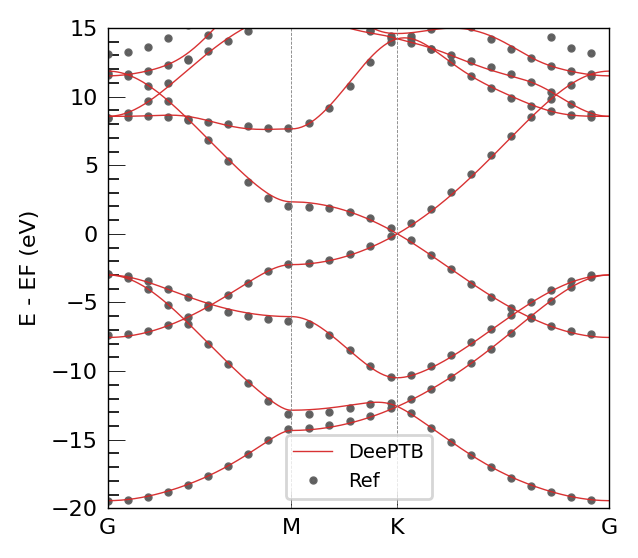

In [5]:
from dptb.postprocess.bandstructure.band import Band
import shutil

task_options = {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[
                [0, 0, 0, 110],
                [0.5, 0, 0, 62],
                [0.3333333, 0.3333333, 0, 127],
                [0, 0, 0, 1]
                ],
        "klabels":["G", "M", "K", "G"],
        "emin":-20,
        "emax": 15,
        "nel_atom":{"C": 4},
        "ref_band": "./train/data/kpath.0/eigenvalues.npy"

       }

if os.path.isdir(results_path):
    shutil.rmtree(results_path, ignore_errors=True) 

band = Band(model, results_path)
AtomicData_options = { "pbc": True}
band.get_bands(data = atoms, 
               kpath_kwargs = task_options,
               AtomicData_options = AtomicData_options)
band.band_plot(emin = task_options['emin'],
               emax = task_options['emax'],
               ref_band = task_options['ref_band'],)

### 1.2 Principal layer and self-energy calculation

Now we can pay attention to quantum transport simulaitons.

In [7]:
try:
    from dpnegf.runner.NEGF import NEGF
except ImportError as e:
    raise ImportError("dpnegf not found. Please install firstly.") from e

import json
negf_input_file =  "negf.json" 
structure =  "stru_negf.xyz" 

with open(negf_input_file, "r") as f:
    negf_json = json.load(f)


DPNEGF INFO    Numba is available and JIT functions are compiled.


A critical component is `AtomicData_options`, which specifies the cutoff parameters for the model:
- `r_max`: the cutoff value for bond considering in TB model
- `er_max`: the cutoff value for environment correction, should set for nnsk+env correction model
- `oer_max`: the cutoff value for onsite correction in nnsk model, need to set in strain mode

In other words, `AtomicData_options` determines the **locality** of the model, i.e., how far atomic interactions are considered in the calculation.

The code would determine the `AtomicData_options` automatically with DeePTB v2.2. At the same time, it can be visiualized conviently
by `NEGF.update_atomicdata_options`.

In [14]:
AtomicData_options = NEGF.update_atomicdata_options(model)

DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }


The largest cutoff value determines the maximum interaction distance, which is critical for defining the electrode geometry in NEGF simulations.

A key requirement of the self-energy algorithm implemented in `DPNEGF` is to define two **principal layers** (PL) for each electrode. The length of each PL must exceed the maximum interaction distance to ensure correct treatment of interactions. In other words, the PLs are restricted to **nearest-neighbor** interactions only.

Additionally, the algorithm requires that the PLs within the same electrode be identical, **differing only by a translation** along the transport direction.

<div style="text-align: center;">
    <img src="./stru_negf_PL.png" alt="jupyter" style="width:80%;"/>
</div>

In [7]:
# Gamma point calculation
negf_json['task_options']["stru_options"]['kmesh'] = [1,1,1]

In [8]:
# Energy step and range for transmission calculation
negf_json['task_options']['espacing'], negf_json['task_options']['emin'], negf_json['task_options']['emax']

(0.05, -10, 10)

In [9]:
# Structural information for device and electrodes
negf_json['task_options']["stru_options"]

{'gamma_center': False,
 'time_reversal_symmetry': True,
 'nel_atom': {'C': 4},
 'kmesh': [1, 1, 1],
 'pbc': [False, True, False],
 'device': {'id': '32-64', 'sort': True},
 'lead_L': {'id': '0-32',
  'voltage': 0.0,
  'kmesh_lead_Ef': [1, 50, 20],
  'useBloch': False},
 'lead_R': {'id': '64-96',
  'voltage': 0.0,
  'kmesh_lead_Ef': [1, 50, 20],
  'useBloch': False}}

- 提示：自能计算对于非自洽NEGF计算几乎可认为是最为关键的环节
- Princpal Layer的选择应当大于max[r_max, er_max, oer_max]
- 以下计算在cpu with 8 cores 需要约2min

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 1
DPNEGF INFO    k-points: [[-0. -0. -0.]]
DPNEGF INFO    k-points weights: [1.]
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732051e-10 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732061e-10 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 72.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferent methods have slight differences   RMSE = 0.0000006.
DP

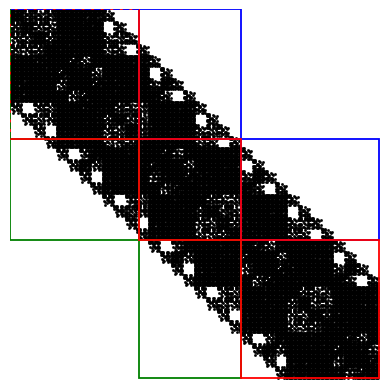

In [10]:
output = "./negf_output"  
if os.path.isdir(output):
    shutil.rmtree(output, ignore_errors=True)
os.makedirs(output, exist_ok=True)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,
    use_saved_se=False, # whether to use the saved self-energy  
    se_info_display=False,
    **negf_json['task_options']
)
   
negf.compute()

In [16]:
import torch
import matplotlib.pyplot as plt
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

In [17]:
output

'./negf_output'

In [18]:
negf_out.keys()

dict_keys(['k', 'wk', 'uni_grid', 'DOS', 'T_k', 'LDOS', 'T_avg'])

In [19]:
negf_out['k']

array([[-0., -0., -0.]])

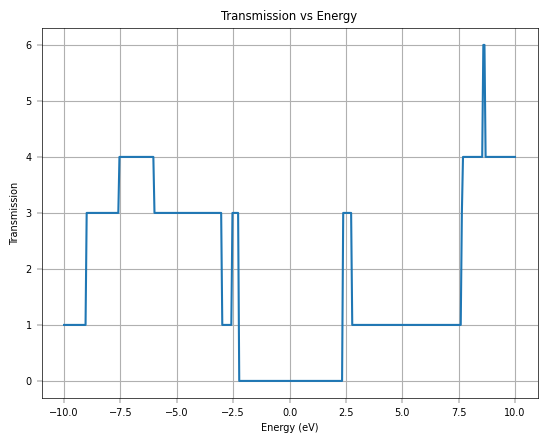

In [20]:
plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy')
plt.grid()
plt.show()

In [21]:
# Increase k-point sampling for better accuracy
negf_json['task_options']["stru_options"]['kmesh'] = [1,20,1]

In [22]:
negf_json['task_options']

{'task': 'negf',
 'scf': False,
 'block_tridiagonal': True,
 'ele_T': 300,
 'unit': 'eV',
 'stru_options': {'gamma_center': False,
  'time_reversal_symmetry': True,
  'nel_atom': {'C': 4},
  'kmesh': [1, 20, 1],
  'pbc': [False, True, False],
  'device': {'id': '32-64', 'sort': True},
  'lead_L': {'id': '0-32',
   'voltage': 0.0,
   'kmesh_lead_Ef': [1, 50, 20],
   'useBloch': False},
  'lead_R': {'id': '64-96',
   'voltage': 0.0,
   'kmesh_lead_Ef': [1, 50, 20],
   'useBloch': False}},
 'density_options': {'method': 'Fiori', 'integrate_way': 'direct'},
 'poisson_options': {'solver': 'fmm', 'err': 1e-05},
 'sgf_solver': 'Sancho-Rubio',
 'espacing': 0.05,
 'emin': -10,
 'emax': 10,
 'eta_lead': 1e-05,
 'eta_device': 0.0,
 'out_dos': True,
 'out_tc': True,
 'out_ldos': True,
 'out_current_nscf': False}

For kmesh=[1,20,1], it takes ~23 mins in cpu8 from scratch. However, if you use the saved self-energies, it takes ~6 mins.

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 10
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732051e-10 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732061e-10 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 72.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferent methods have slight differences   RMSE = 0.0000006.
DPNEGF INFO    The coupling width of lead_R is 72.
DPNEGF WARNING WARNING, the l

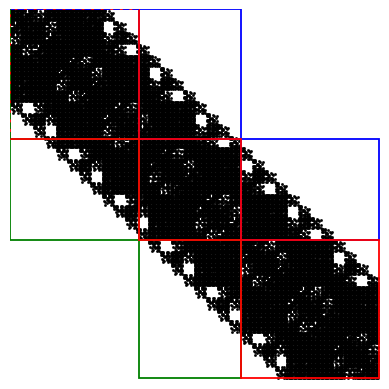

In [23]:
output = "./negf_output_k20"

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output, 
    use_saved_se=True,   # use the saved self-energy to speed up calculation
    **negf_json['task_options']
)
   
negf.compute()

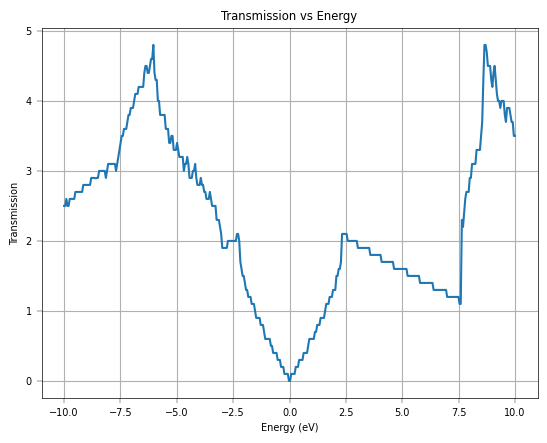

In [19]:
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy')
plt.grid()
plt.show()

In [2]:
import os
import torch

output = 'negf_output_k100'
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

negf_out.keys()

dict_keys(['k', 'wk', 'E', 'T_k', 'T_avg', 'BIAS_POTENTIAL_NSCF', 'CURRENT_NSCF'])

In [3]:
negf_out['T_avg'].shape

torch.Size([600])

In [4]:
import numpy as np
Erange = np.linspace(-15,15,int((15-(-15))/0.05))

In [13]:
import sisl 
tbt_k = sisl.get_sile(os.path.join(output, 'siesta.TBT.nc'))

In [14]:
tbt_k.E

array([-39.99464308, -39.98464317, -39.97464326, ..., -10.02491054,
       -10.01491063, -10.00491072])

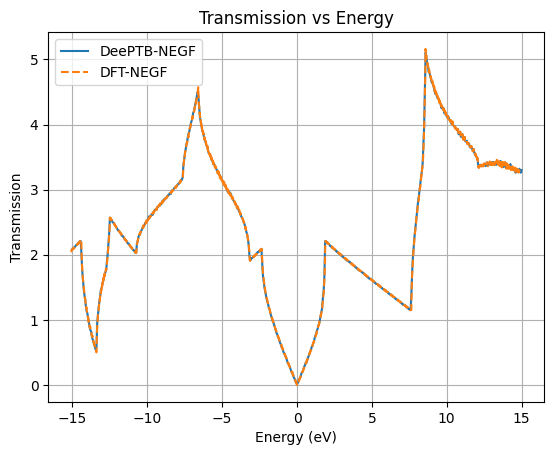

In [17]:
import matplotlib.pyplot as plt
plt.plot(Erange, negf_out['T_avg'], label='DeePTB-NEGF')

Ef_TS = -24.878582000732422
plt.plot(tbt_k.E - Ef_TS, tbt_k.transmission(),'--', label=r'DFT-NEGF')
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy')
plt.grid()
plt.legend()
plt.show()

For kmesh=[1,50,1], it takes ~40 mins in cpu8.

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 25
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732051e-10 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732061e-10 (threshold: 1.000000e-05)
/opt/mamba/envs/dpnegf-dev/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:1

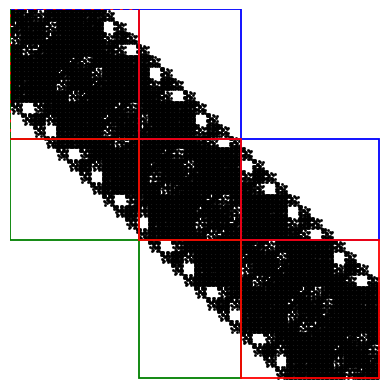

In [5]:
negf_json['task_options']["stru_options"]['kmesh'] = [1,50,1]
negf_json['task_options']['emin'] = -5
negf_json['task_options']['emax'] = 5

output = "./negf_output_k50"
if os.path.isdir(output):
    shutil.rmtree(output, ignore_errors=True)
os.makedirs(output)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,  
    **negf_json['task_options']
)
   
negf.compute()

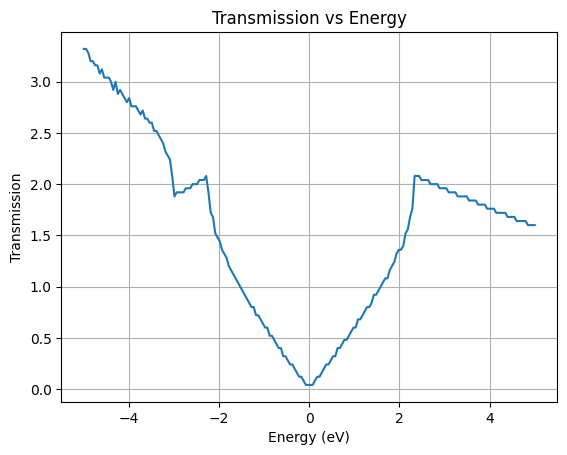

In [8]:
import torch
import matplotlib.pyplot as plt
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy')
plt.grid()
plt.show()